### Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

%matplotlib inline

### Config from modules for ipynb

In [3]:
import ipynb
import importlib
import ipynb.fs.full.modules.Config as ipynb_config

In [4]:
importlib.reload(ipynb_config)

<module 'ipynb.fs.full.modules.Config' (/Users/dieumynguyen/Desktop/Projects/bee_communication_v2/ipynb/modules/Config.ipynb)>

In [5]:
X_MIN = ipynb_config.X_MIN
X_MAX = ipynb_config.X_MAX
DX = ipynb_config.DX
GRID_SIZE = np.arange(X_MIN, X_MAX+DX, DX).shape[0]
D = ipynb_config.DIFFUSION_COEFFICIENT
DECAY = ipynb_config.DECAY
T_MIN = ipynb_config.T_MIN
T_MAX = ipynb_config.T_MAX
DT = ipynb_config.DT
NUM_TIMESTEPS = np.arange(T_MIN, T_MAX+DT, DT).shape[0]
QUEEN_BEE_A = ipynb_config.QUEEN_INITIAL_CONCENTRATION
WORKER_BEE_A = ipynb_config.WORKER_INITIAL_CONCENTRATION
THRESHOLD = ipynb_config.WORKER_THRESHOLD
WB = ipynb_config.WORKER_BIAS_SCALAR
SEED = ipynb_config.RANDOM_SEED

In [6]:
convert_xy_to_index = lambda xy: ((xy - X_MIN) / (X_MAX - X_MIN)) * GRID_SIZE

### Config from script 

In [7]:
def read_config(base_exp_dir):
    cfg_path = glob2.glob(f"{base_exp_dir}/*.cfg")[0]
    cfg_path, os.path.exists(cfg_path)

    with open(cfg_path, "r") as infile:
        lines = [line.split() for line in infile]
        cfg_opts = {}
        for key, val in lines:
            key = key.replace('--', '')

            try:
                val = float(val)
            except:
                try:
                    val = int(val)
                except:
                    if val.startswith("T"):
                        val = True
                    elif val.startswith("F"):
                        val = False
                    pass
            cfg_opts[key] = val
    return cfg_opts

In [8]:
# base_exp_dir = "../script/experiments/experiment_2__2019-02-18_20-03-02/Q0.15_W0.15_D0.6_T0.0100_wb5.0_decay18.0_seed0"
base_exp_dir = "forConcentration_Q0.15_W0.15_D0.6_T0.0250_wb5.0_decay18.0_seed24"
os.path.exists(base_exp_dir)


True

In [9]:
script_config = read_config(base_exp_dir)

### Read h5 data & visualization

In [10]:
ipynb_dev_config = False

In [11]:
if not ipynb_dev_config:
    env_path = os.path.join(base_exp_dir, "envir_hist.h5")
    bee_path = os.path.join(base_exp_dir, "bee_hist.h5")
    print(os.path.exists(env_path), os.path.exists(bee_path), env_path)
else: 
    base_exp_dir = "./"
    env_path = os.path.join(base_exp_dir, "envir_hist.h5")
    bee_path = os.path.join(base_exp_dir, "bee_hist.h5")
    print(os.path.exists(env_path), os.path.exists(bee_path), env_path)


False True forConcentration_Q0.15_W0.15_D0.6_T0.0250_wb5.0_decay18.0_seed24/envir_hist.h5


- #### Concentration maps

In [21]:
with h5py.File(env_path, 'r') as infile:
    cmaps = np.array(infile['concentration'])

In [175]:
# Min and max concentrations for heatmap
min_c = np.min(cmaps[:501])
max_c = np.max(cmaps[:501]) * 0.8
min_c, max_c

(0.0, 0.9887049674987793)

- #### Bee measurements

In [12]:
bee_data = {}
with h5py.File(bee_path, 'r') as infile:
    for key, val in infile.items():
        bee_data[key] = np.array(val)

In [13]:
bee_data.keys()

dict_keys(['bee_i', 'concentration', 'distance_from_queen', 'gradient_x', 'gradient_y', 'state', 't', 'threshold_met', 'wx', 'wy', 'x', 'y'])

In [14]:
bee_nums = np.unique(bee_data['bee_i'])
bees = {}
for bee_num in bee_nums:
    idxs = np.where(bee_data['bee_i']==bee_num)
    bee_x = bee_data['x'][idxs]
    bee_y = bee_data['y'][idxs]
    bee_state = bee_data['state'][idxs]
    distance = bee_data['distance_from_queen'][idxs]
    bee_grads = bee_data['gradient_x'][idxs], bee_data['gradient_y'][idxs]
    bias = bee_data['wx'][idxs], bee_data['wy'][idxs]
    concentration = bee_data['concentration'][idxs]
    threshold_met = bee_data['threshold_met'][idxs]
    bees[bee_num] = {"x" : bee_x, "y" : bee_y, "state": bee_state,
                    "distance": distance, "grads" : bee_grads,
                    "concentration": concentration, 
                     "threshold_met" : threshold_met}

### Plot concentration before scenting

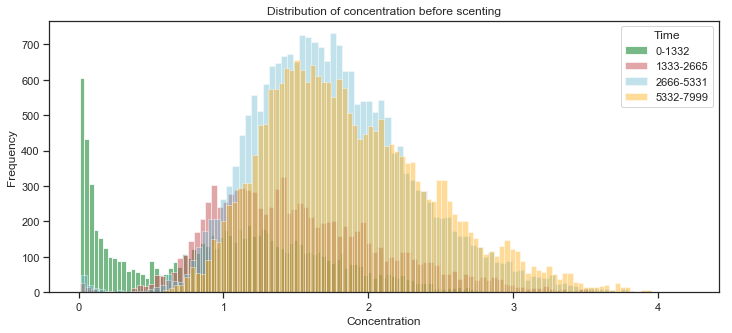

In [30]:
sns.set(style="ticks")
time = len(bees[0]['state'])
time_array = np.arange(0, time)
div = int(len(time_array) / 3)
time_1 = time_array[0:div]
time_1a = time_1[:len(time_1)//2]
time_1b = time_1[time_1a[-1]+1:len(time_1a)*2]
time_2 = time_array[div:div*2]
time_3 = time_array[div*2:]

before_scenting_only = True

concentrations_1a = []
concentrations_1b = []
concentrations_2 = []
concentrations_3 = []

for bee_i, bee in enumerate(bees):
    single_bee = bees[bee_i]
    
    for t in time_1a:
        state = single_bee['state'][t]
        threshold_met = single_bee['threshold_met'][t]

        if before_scenting_only:
            if state == 1:
                concentration = single_bee['concentration'][t-1]
                concentrations_1a.append(concentration)
        else:
            if state == 1 or state == 3:
                concentration = single_bee['concentration'][t-1]
                concentrations_1a.append(concentration)
                
    for t in time_1b:
        state = single_bee['state'][t]
        threshold_met = single_bee['threshold_met'][t]

        if before_scenting_only:
            if state == 1:
                concentration = single_bee['concentration'][t-1]
                concentrations_1b.append(concentration)
        else:
            if state == 1 or state == 3:
                concentration = single_bee['concentration'][t-1]
                concentrations_1b.append(concentration)
                
    for t in time_2:
        state = single_bee['state'][t]
        threshold_met = single_bee['threshold_met'][t]

        if before_scenting_only:
            if state == 1:
                concentration = single_bee['concentration'][t-1]
                concentrations_2.append(concentration)
        else:
            if state == 1 or state == 3:
                concentration = single_bee['concentration'][t-1]
                concentrations_2.append(concentration)
                
    for t in time_3:
        state = single_bee['state'][t]
        threshold_met = single_bee['threshold_met'][t]

        if before_scenting_only:
            if state == 1:
                concentration = single_bee['concentration'][t-1]
                concentrations_3.append(concentration)
        else:
            if state == 1 or state == 3:
                concentration = single_bee['concentration'][t-1]
                concentrations_3.append(concentration)

plt.figure(figsize=(12, 5))
plt.hist(concentrations_1a, color="g", alpha=0.8, bins=100, label=f"0-{time_1a[-1]}")
plt.hist(concentrations_1b, color="r", alpha=0.5, bins=100, label=f"{time_1b[0]}-{time_1b[-1]}")
plt.hist(concentrations_2, color="c", alpha=0.4, bins=100, label=f"{time_2[0]}-{time_2[-1]}")
plt.hist(concentrations_3, color="orange", alpha=0.4, bins=100, label=f"{time_3[0]}-{time_3[-1]}")
plt.xlabel("Concentration")
plt.ylabel("Frequency")
plt.legend(title="Time")
# plt.ylim(0, 650)
if before_scenting_only:
    plt.title(f'Distribution of concentration before scenting')
    plt.savefig(f'worker_concentration/before_scenting_{base_exp_dir}.png')
else:
    plt.title(f'Distribution of concentration before scenting OR directed walk')
    plt.savefig(f'worker_concentration/before_scenting_or_directed_{base_exp_dir}.png')
plt.show()

### Make frames

In [176]:
colors = ["red", "gray", "#479030", "orange", "blue"]
color_decoder = {
    0: colors[1],
    1: colors[2],
    2: colors[2],
    3: colors[3],
    4: colors[4]
}

In [177]:
plt.rcParams["font.family"] = "Arial"

In [178]:
TIME = cmaps.shape[0]

In [179]:
# !rm experiments/*.png
# min_c = None
# max_c = None
savepath = ""
for frame_i in range(cmaps.shape[0]):
    sys.stdout.write(f"\rFrame {frame_i+1}/{TIME}")
    sys.stdout.flush()
    
    # CONCENTRATION
    cmap = cmaps[frame_i]
    plt.imshow(cmap, cmap='Greens', vmin=min_c, vmax=max_c)
    plt.colorbar(shrink=0.8, format='%.2f')  
    
    # QUEEN
    queen = convert_xy_to_index(0)
    plt.scatter(queen, queen, c="red", s=100, edgecolors='black', marker='o')     
    
    # WORKERS
    for bee_key, bee_vals in bees.items():
        x = bee_vals['x'][frame_i]
        y = bee_vals['y'][frame_i]
        state = bee_vals['state'][frame_i]
        color = color_decoder[state]
        plt.scatter(convert_xy_to_index(x), convert_xy_to_index(y), 
                    color=color, s=30, edgecolors='black')
        
    # FORMATTING
    texts = ["Queen", "Random walk pre-scenting", "Scenting", "Directed walk", "Random walk post-scenting"]
    patches = [ plt.plot([],[], marker="o", ms=5, ls="", mec=None, color=colors[i], 
                markeredgecolor="black", label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.22), 
               loc='center', ncol=2, numpoints=1, labelspacing=0.3,
               fontsize='small', fancybox="True",
               handletextpad=0, columnspacing=0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, 600)
    plt.ylim(600, 0) 

    if ipynb_dev_config:
        plt.title(f"Q{QUEEN_BEE_A}_W{WORKER_BEE_A}_D{D}_T{THRESHOLD}_wb{WB}_decay{DECAY}_seed{SEED} \n t: {frame_i+1}/{TIME-1}")
    else:
        num_timesteps = np.arange(script_config['t_min'], script_config['t_max']+script_config['dt'], script_config['dt']).shape[0]
        Q = script_config['queen_initial_concentration']
        W = script_config['worker_initial_concentration']
        D = script_config['diffusion_coefficient']
        T = script_config['worker_threshold']
        wb = int(script_config['worker_bias_scalar'])
        decay = int(script_config['decay'])
        seed = int(script_config['random_seed'])
        title = f"Q{Q}_W{W}_D{D}_T{T:0.5f}_wb{wb}_decay{decay}"
        savepath = f"{title}_seed{seed}.mp4"
        plt.title(f"{title} \n t: {frame_i+1}/{TIME-1}")
          
    # SAVING FRAMES
    file_path = f't{frame_i+1:03d}.png'
    filename = f'{ipynb_config.SAVE_FOLDER}/{file_path}' 
    plt.savefig(filename, bbox_inches='tight', dpi=100)
    plt.close()

Frame 200/200

## Video Stuff

In [180]:
all_img_paths = np.sort(glob2.glob("experiments/*.png"))
all_imgs = np.array([cv2.imread(img) for img in all_img_paths])

def imgs2vid(imgs, outpath, fps=4):
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
    video = cv2.VideoWriter(outpath, fourcc, fps, (width, height), True)
    
    for img in imgs:
        video.write(img)
        
    cv2.destroyAllWindows()
    video.release()
    
if ipynb_dev_config:
    imgs2vid(all_imgs, ipynb_config.VID_PATH)
else:
    savepath = f"experiments/{savepath}"
    imgs2vid(all_imgs, savepath)


In [ ]:
# Slow as hell 
# if ipynb_dev_config:
#     !convert -delay 25 $ipynb_config.SAVE_FOLDER/t*.png $ipynb_config.VID_PATH
# else: 
#     savepath = f"experiments/{savepath}"
#     !convert -delay 25 $ipynb_config.SAVE_FOLDER/t*.png $savepath


In [42]:
VLC = "/Applications/VLC.app/Contents/MacOS/VLC"
!$VLC $config.VID_PATH

/bin/sh: .VID_PATH: command not found


In [1]:
import numpy as np

In [2]:
x = np.zeros((80, 600, 600), dtype=np.float16)
x.dtype, f"{x.nbytes / 1e9} GB"

(dtype('float16'), '0.0576 GB')

In [3]:
y = np.ones((80, 600, 600), dtype=np.float32)
y.dtype, f"{y.nbytes / 1e9} GB"

(dtype('float32'), '0.1152 GB')

In [4]:
x += y
x.dtype

dtype('float16')

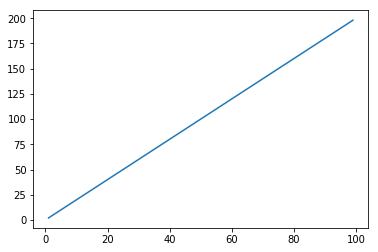

In [6]:
x = np.arange(1, 100)
y = x * 2
plt.plot(x, y);

In [71]:
time = 8000
iss = []
for i in range(0, time, 10):
    iss.append(i)
    
len(iss)

800